<a href="https://colab.research.google.com/github/yong1yan/sps_genai/blob/main/Assignment3_ym3079.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.utils import make_grid
!pip install torchinfo

from tqdm import tqdm
from IPython.display import clear_output

In [29]:
BATCH_SIZE = 128

In [30]:
# Data: MNIST to [-1,1] for Tanh
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)


In [31]:
# ===== 2) Models =====
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.fc = nn.Linear(z_dim, 128 * 7 * 7)
        self.conv_layers = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 7->14
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),   # 14->28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 128, 7, 7)
        x = self.conv_layers(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),   # 28->14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # 14->7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.fc = nn.Linear(7 * 7 * 128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

In [32]:
# ===== 3) Setup =====
z_dim = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen = Generator(z_dim).to(device)
disc = Discriminator().to(device)

criterion = nn.BCELoss()
lr = 0.0002
opt_gen  = optim.Adam(gen.parameters(),  lr=lr, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))

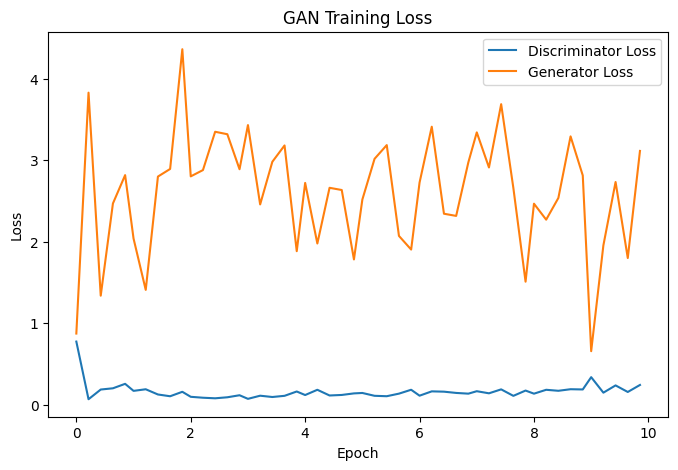

Epoch 10/10: 100%|██████████████████████████████████████| 469/469 [00:16<00:00, 28.37it/s, D Loss=0.2444, G Loss=3.1137]


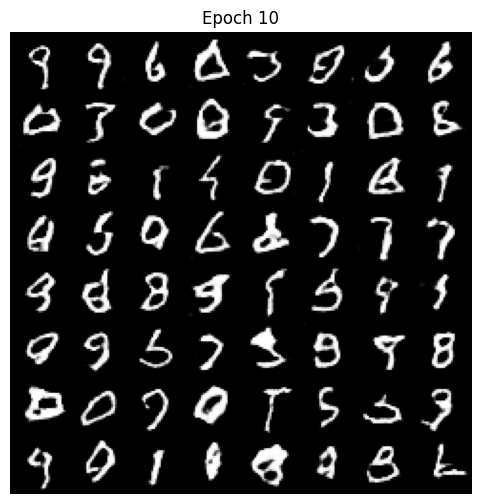

In [33]:
# ===== 4) Training Loop =====
epochs = 10
fixed_noise = torch.randn(64, z_dim, device=device)  # for visualization
datalogs = []

gen.train(); disc.train()
for epoch in range(epochs):
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", ncols=120)
    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(device)
        bsz = real.size(0)

        # ---- Train D ----
        noise = torch.randn(bsz, z_dim, device=device)
        fake  = gen(noise)

        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))

        disc_fake = disc(fake.detach()).view(-1)      # <-- detach!
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

        lossD = (lossD_real + lossD_fake) / 2

        disc.zero_grad()
        lossD.backward()
        opt_disc.step()

        # ---- Train G ----
        output = disc(fake).view(-1)                   # re-evaluate without detach
        lossG = criterion(output, torch.ones_like(output))

        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        # ---- Logs & live plot ----
        if batch_idx % 100 == 0:
            loop.set_postfix({"D Loss": f"{lossD.item():.4f}", "G Loss": f"{lossG.item():.4f}"})
            datalogs.append({
                "epoch": epoch + batch_idx / len(dataloader),
                "D loss": lossD.item(),
                "G loss": lossG.item()
            })
            clear_output(wait=True)
            plt.figure(figsize=(8,5))
            plt.plot([d["epoch"] for d in datalogs], [d["D loss"] for d in datalogs], label="Discriminator Loss")
            plt.plot([d["epoch"] for d in datalogs], [d["G loss"] for d in datalogs], label="Generator Loss")
            plt.xlabel("Epoch"); plt.ylabel("Loss")
            plt.legend(); plt.title("GAN Training Loss")
            plt.show()

    with torch.no_grad():
        fake_grid = gen(fixed_noise).detach().cpu()
    grid = make_grid(fake_grid, normalize=True)
    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(f"Epoch {epoch+1}")
    plt.axis("off"); plt.show()